## Ciruclation budget calculation
- calculates the circulation budget at 700 hPa (using data in pressure levels)
- circulation tendency and advection terms
- titling ignored (this requires vertical derivatives/computationally expensive)
- uses both area and line integral versions (results should be the same)

Author: Corey Robinson

In [1]:
#Data libraries:
import xarray as xr
import numpy as np

# Plotting libraries:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mticker
from matplotlib.ticker import ScalarFormatter
from matplotlib.patches import Polygon
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
%matplotlib inline
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import glob as glob
import pandas as pd

In [2]:
# Let's load Dask to make Xarray more efficient
import dask.distributed as dsk
import dask

# Start client
try:
    clnt
except:
    clnt = dsk.Client()
    clnt

In [3]:
# roughly the area of the floods
min_lon, max_lon = 147.5, 157.5
min_lat, max_lat = -32.5, -22.5
level = 700e2 # 700 hPa

datadir = '/g/data/hh5/tmp/WACI-Hackathon-2023/AUS2200/data/'

#mlev_path = '/g/data/hh5/tmp/WACI-Hackathon-2023/AUS2200/netcdf/day1/history/atm/netCDF/umnsa_mdl*.nc'
u_files = datadir+'u_plev_1hr*.nc'
v_files = datadir+'v_plev_1hr*.nc'

In [4]:
# from Raina, removes issues with pressure level labels
# (might be fixed now?)
def preprocess(ds):
    return ds.drop_duplicates('plev')

In [5]:
%%time
# load the pressure level data

u=xr.open_mfdataset(u_files,concat_dim='time',combine="nested",
                         chunks={'plev':2,"latitude":200,"longitude":200})['u'] # ,preprocess=preprocess,
u=u.sel(longitude=slice(min_lon, max_lon), latitude=slice(min_lat, max_lat), plev=level)

v=xr.open_mfdataset(v_files,concat_dim='time',combine="nested",
                         chunks={'plev':2,"latitude":200,"longitude":200})['v'] # ,preprocess=preprocess,
v=v.sel(longitude=slice(min_lon, max_lon), latitude=slice(min_lat, max_lat), plev=level)

u

CPU times: user 2.66 s, sys: 1.27 s, total: 3.93 s
Wall time: 5.24 s


<xarray.DataArray 'u' (time: 336, latitude: 505, longitude: 505)>
dask.array<getitem, shape=(336, 505, 505), dtype=float32, chunksize=(24, 200, 200), chunktype=numpy.ndarray>
Coordinates:
    plev       float32 7e+04
  * latitude   (latitude) float32 -32.49 -32.47 -32.45 ... -22.55 -22.53 -22.51
  * longitude  (longitude) float32 147.5 147.5 147.6 147.6 ... 157.5 157.5 157.5
  * time       (time) datetime64[ns] 2022-02-22T01:00:00 ... 2022-03-08
Attributes:
    cell_methods:   time: mean
    units:          m s-1
    standard_name:  eastward_wind

In [6]:
# constants

g = 9.81 # gravitational constant
R_e = 6371e3 # radius of Earth
R_d = 287 # Dry gas constant
omega = (2*np.pi) / (24*60*60)

In [7]:
def rel_vort(u, v):
    """
    vertical component of relative vorticity
    """

    lats_rad, lons_rad = u.latitude * np.pi/180, u.longitude * np.pi/180

    # 180/pi comes out when converting degrees to radians
    dv_dl = v.differentiate('longitude') * 180/np.pi

    rv = u * np.cos(lats_rad)
    rv = -rv.differentiate('latitude') * 180/np.pi
    rv += dv_dl
    rv *= 1/(R_e * np.cos(lats_rad))
    
    return rv


def spherical_area_mean(data):
    """
    takes the mean over a lat/lon box in spherical coordinates
    """
    cosphi = np.cos(np.deg2rad(data.latitude))
    data_mean = data * cosphi
    data_mean = data_mean.integrate(['latitude', 'longitude']) * (np.pi/180)**2 
    data_mean /= np.deg2rad(max_lon - min_lon) * (np.sin(np.deg2rad(max_lat)) - np.sin(np.deg2rad(min_lat))) # normalise by box area
    
    return data_mean


def add_rad_coords(data):
    """
    Adds new coords for latitude/longitude in radiations for differentiation/integration
    """
    data = data.assign_coords(lonrad = ('longitude', np.deg2rad(data.longitude.values)))
    data = data.assign_coords(latrad = ('latitude', np.deg2rad(data.latitude.values)))
    return data


def moving_average(data, n=24):
    data = xr.DataArray(data, dims = ['time'])
    data = data.fillna(0)
    data = data.rolling(time=n, center=True).mean().dropna('time')
    return data

In [8]:
rv = rel_vort(u, v)
rv

<xarray.DataArray (time: 336, latitude: 505, longitude: 505)>
dask.array<mul, shape=(336, 505, 505), dtype=float32, chunksize=(24, 200, 200), chunktype=numpy.ndarray>
Coordinates:
    plev       float32 7e+04
  * latitude   (latitude) float32 -32.49 -32.47 -32.45 ... -22.55 -22.53 -22.51
  * longitude  (longitude) float32 147.5 147.5 147.6 147.6 ... 157.5 157.5 157.5
  * time       (time) datetime64[ns] 2022-02-22T01:00:00 ... 2022-03-08

CPU times: user 1.36 s, sys: 858 ms, total: 2.21 s
Wall time: 5.59 s


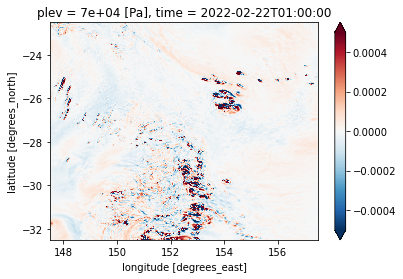

In [9]:
%%time
rv.isel(time=0).plot(vmax=5e-4)

In [10]:
# absolute vorticity (add f)

lats_rad = np.deg2rad(rv.latitude)
cosphi = np.cos(lats_rad)
sinphi = np.sin(lats_rad)
f = 2 * omega * sinphi
av = rv + f
av

<xarray.DataArray (time: 336, latitude: 505, longitude: 505)>
dask.array<add, shape=(336, 505, 505), dtype=float32, chunksize=(24, 200, 200), chunktype=numpy.ndarray>
Coordinates:
    plev       float32 7e+04
  * latitude   (latitude) float32 -32.49 -32.47 -32.45 ... -22.55 -22.53 -22.51
  * longitude  (longitude) float32 147.5 147.5 147.6 147.6 ... 157.5 157.5 157.5
  * time       (time) datetime64[ns] 2022-02-22T01:00:00 ... 2022-03-08

CPU times: user 984 ms, sys: 139 ms, total: 1.12 s
Wall time: 1.96 s


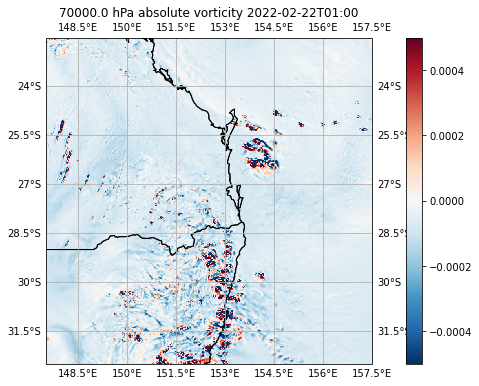

In [11]:
%%time

# plot 1 time for absolute vorticity

fig = plt.figure(figsize=(12, 6))
[lats, lons] = np.meshgrid(av.latitude, av.longitude, indexing='ij')

time_format = str(av.time.values[0])[:16]


ax = plt.axes(projection=ccrs.PlateCarree())
quad = ax.pcolormesh(lons, lats, av.isel(time=0), vmin=-5e-4, vmax=5e-4, cmap='RdBu_r')
ax.coastlines(color='k')
gl = ax.gridlines(draw_labels=True)
ax.add_feature(cfeature.STATES)
ax.set_title(f'{level} hPa absolute vorticity {time_format}')
plt.colorbar(quad)

In [12]:
# meridional absolute vorticity flux (assumiing density = 1)

av_flux = v * av

CPU times: user 892 ms, sys: 46.3 ms, total: 938 ms
Wall time: 1.9 s


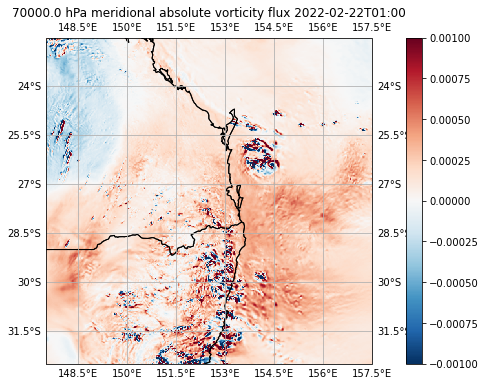

In [13]:
%%time

fig = plt.figure(figsize=(12, 6))
[lats, lons] = np.meshgrid(av.latitude, av.longitude, indexing='ij')

time_format = str(av.time.values[0])[:16]


ax = plt.axes(projection=ccrs.PlateCarree())
quad = ax.pcolormesh(lons, lats, av_flux.isel(time=0), vmin=-1e-3, vmax=1e-3, cmap='RdBu_r')
ax.coastlines(color='k')
gl = ax.gridlines(draw_labels=True)
ax.add_feature(cfeature.STATES)
ax.set_title(f'{level} hPa meridional absolute vorticity flux {time_format}')
plt.colorbar(quad)

In [14]:
%%time
# calculate circulation (as an area integral)
#C = rv.mean(dim=['latitude', 'longitude']).compute()
C = spherical_area_mean(rv).compute()

CPU times: user 4.55 s, sys: 272 ms, total: 4.82 s
Wall time: 9.94 s


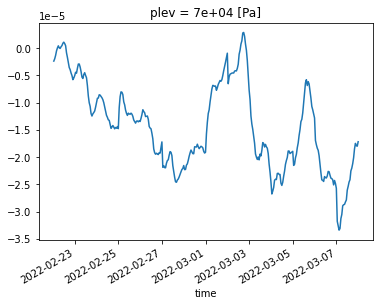

In [15]:
C.plot()

In [16]:
# add lat/lon coords in radians to data
u = add_rad_coords(u)
v = add_rad_coords(v)
rv = add_rad_coords(rv)
av = add_rad_coords(av)

u

<xarray.DataArray 'u' (time: 336, latitude: 505, longitude: 505)>
dask.array<getitem, shape=(336, 505, 505), dtype=float32, chunksize=(24, 200, 200), chunktype=numpy.ndarray>
Coordinates:
    plev       float32 7e+04
  * latitude   (latitude) float32 -32.49 -32.47 -32.45 ... -22.55 -22.53 -22.51
  * longitude  (longitude) float32 147.5 147.5 147.6 147.6 ... 157.5 157.5 157.5
  * time       (time) datetime64[ns] 2022-02-22T01:00:00 ... 2022-03-08
    lonrad     (longitude) float32 2.575 2.575 2.575 2.576 ... 2.748 2.748 2.749
    latrad     (latitude) float32 -0.5671 -0.5668 -0.5664 ... -0.3933 -0.3929
Attributes:
    cell_methods:   time: mean
    units:          m s-1
    standard_name:  eastward_wind

In [17]:
%%time

# Calculate the advection term
adv_x = u * av
adv_y = v * av

# divergence in spherical coords is
adv = 1/(R_e * cosphi) * ((adv_y * cosphi).differentiate('latrad') + adv_x.differentiate('lonrad'))

# calculate vorticity tendency
dav_dt = av.differentiate('time', datetime_unit = 's')

# residual
res = dav_dt + adv

CPU times: user 56.4 ms, sys: 330 µs, total: 56.7 ms
Wall time: 48.6 ms


In [18]:
%%time
dav_dt, adv, res = dask.compute(dav_dt, adv, res)

CPU times: user 6.57 s, sys: 1.44 s, total: 8 s
Wall time: 14 s


In [19]:
# plot options

proj = ccrs.PlateCarree()
formatter = ScalarFormatter()
formatter.set_powerlimits((-3,3))

clevs = np.arange(-5.25e-6, 5.75e-6, 0.5e-6)
[lons, lats] = np.meshgrid(adv.longitude, adv.latitude)

xmin = float(res.longitude.min().values)
xmax = float(res.longitude.max().values)
ymin = float(res.latitude.min().values)
ymax = float(res.latitude.max().values)

def prepare_axes(ax):
    
    ax.coastlines()
    ax.add_feature(cfeature.STATES)
    gl = ax.gridlines(draw_labels=True)
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlocator = mticker.FixedLocator(np.arange(xmin, xmax + 4, 4))
    gl.ylocator = mticker.FixedLocator(np.arange(ymin, ymax + 4, 4))    
    gl.bottom_labels = False
    gl.right_labels = False  

CPU times: user 776 ms, sys: 29.6 ms, total: 806 ms
Wall time: 751 ms


Text(0.5, 1.02, '70000.0 Pa vorticity budget: 2022-02-24 01:00:00')

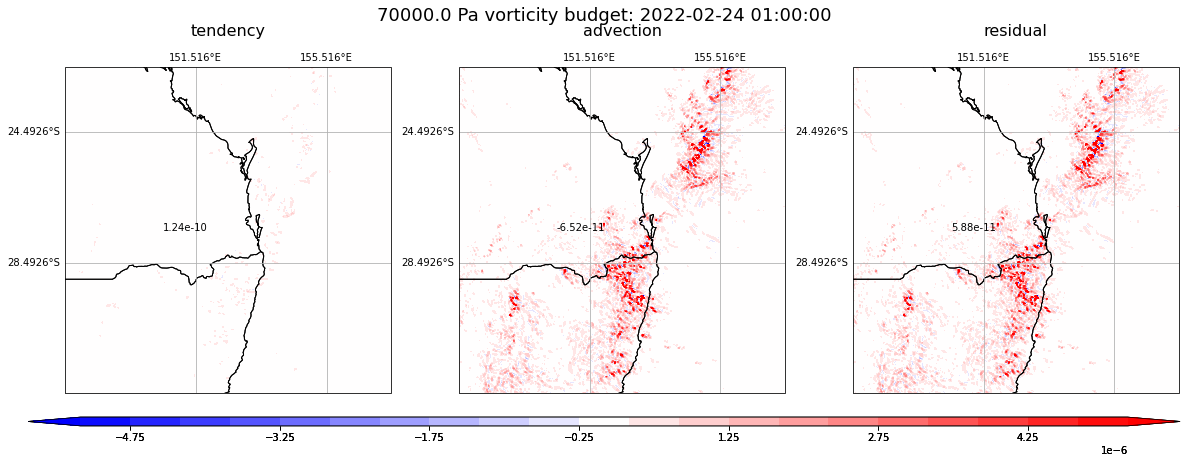

In [20]:
%%time
# plot maps of the terms at 1 particular time

# time index to plot
t = 48

fig, axes = plt.subplots(1, 3, subplot_kw = dict(projection=ccrs.PlateCarree()), figsize = (20, 6))

ax1 = axes[0]
prepare_axes(ax1)
cf1 = ax1.contourf(lons, lats, (dav_dt).isel(time=t), levels = clevs, extend = 'both', cmap = 'bwr')
ax1.set_title('tendency', y = 1.08, fontsize=16)
mean = dav_dt.isel(time=t).mean()
ax1.text(0.3, 0.5, '{:.2e}'.format(mean.values), transform = ax1.transAxes)
cb_ax = fig.add_axes([0.1, 0.05, 0.8, 0.02])
cbar = fig.colorbar(cf1, cax = cb_ax, orientation = 'horizontal', format = formatter)

ax2 = axes[1]
prepare_axes(ax2)
cf2 = ax2.contourf(lons, lats, adv.isel(time=t), levels = clevs, extend = 'both', cmap = 'bwr')
ax2.set_title('advection', y = 1.08, fontsize=16)
mean = adv.isel(time=t).mean()
ax2.text(0.3, 0.5, '{:.2e}'.format(mean.values), transform = ax2.transAxes)
cb_ax = fig.add_axes([0.1, 0.05, 0.8, 0.02])
cbar = fig.colorbar(cf2, cax = cb_ax, orientation = 'horizontal', format = formatter)

ax3 = axes[2]
prepare_axes(ax3)
cf3 = ax3.contourf(lons, lats, res.isel(time=t), levels = clevs, extend = 'both', cmap = 'bwr')
ax3.set_title('residual', y = 1.08, fontsize=16)
mean = res.isel(time=t).mean()
ax3.text(0.3, 0.5, '{:.2e}'.format(mean.values), transform = ax3.transAxes)
cb_ax = fig.add_axes([0.1, 0.05, 0.8, 0.02])
cbar = fig.colorbar(cf3, cax = cb_ax, orientation = 'horizontal', format = formatter)

date_format = str(res.time[t].values)[:10] + ' ' + str(res.time[t].values)[11:19]
plt.suptitle(f'{level} Pa vorticity budget: {date_format}', fontsize = 18, y = 1.02)

In [21]:
# now integrate over the box of interest

tend_mean = spherical_area_mean(dav_dt)
adv_mean = spherical_area_mean(adv)
res_mean = spherical_area_mean(res)

# take average (trying new version now)
tend_mean_smooth = moving_average(tend_mean)
adv_mean_smooth = moving_average(adv_mean)
res_mean_smooth = moving_average(res_mean)

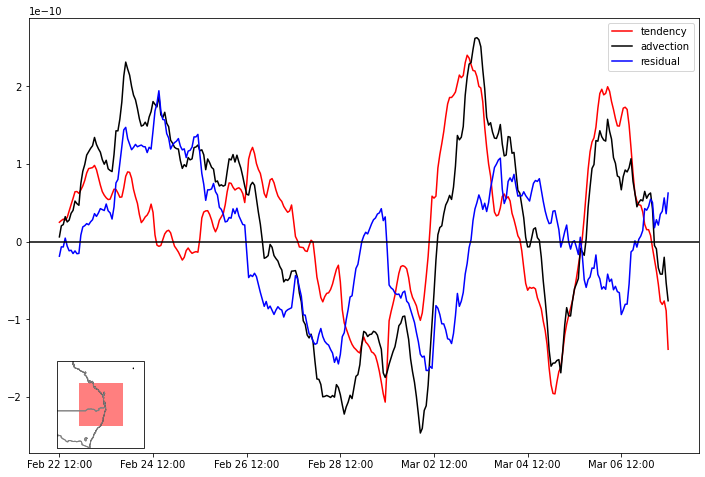

In [22]:
# Time stuff
t = np.arange(len(adv) - 24)
# remove points at end due to 24-point smoothing
times = pd.to_datetime(adv.time.values)[11:-12]
all_times = times.strftime('%b %d %H')
plot_times = times.strftime('%b %d %H:%M')
t = adv.time[11:-12]


plt.figure(figsize=(12,8))
plt.plot(t, -(tend_mean_smooth), label = 'tendency', color = 'r')
plt.plot(t, adv_mean_smooth, label = 'advection', color = 'k')
plt.plot(t, res_mean_smooth, label = 'residual', color = 'b')
    
plt.axhline(color = 'k')
#plt.ylim((-2e-10,2e-10))
plt.xticks(t.values[::48], plot_times[::48])
plt.legend()

axins = inset_axes(plt.gca(), width="20%", height="20%", loc="lower left", 
                   axes_class=cartopy.mpl.geoaxes.GeoAxes, 
                   axes_kwargs=dict(map_projection=ccrs.PlateCarree()))
axins.coastlines()
axins.add_feature(cfeature.STATES, edgecolor='gray')
axins.set_extent((min_lon - 5, max_lon + 5, min_lat - 5, max_lat + 5), crs=ccrs.PlateCarree())

# Shade box on map inset
xy = np.array([[min_lon, min_lat], [max_lon, min_lat], [max_lon, max_lat], [min_lon, max_lat]])
poly = Polygon(xy, facecolor='red', alpha=0.5)
plt.gca().add_patch(poly)

## Line integral version

In [23]:
# convert lon/lat to x/y
dy = np.deg2rad(R_e)
dx = np.deg2rad(R_e * cosphi)
dx_north = dx.sel(latitude=max_lat, method='nearest')
dx_south = dx.sel(latitude=min_lat, method='nearest')

# get area of box (spherical coords/area integral)
# dA = Re^2 cos(phi) dlambda dphi, integrate this over lambda/phi
box_area = R_e**2 * np.deg2rad(max_lon - min_lon) * (np.sin(np.deg2rad(max_lat)) - np.sin(np.deg2rad(min_lat)))
box_area

1095336363206.029

In [24]:
u_south = u.sel(longitude=slice(min_lon,max_lon)).sel(latitude=min_lat, method='nearest')
v_east = v.sel(latitude=slice(min_lat,max_lat)).sel(longitude=max_lon, method='nearest')
u_north = u.sel(longitude=slice(min_lon,max_lon)).sel(latitude=max_lat, method='nearest')
v_west = v.sel(latitude=slice(min_lat,max_lat)).sel(longitude=min_lon, method='nearest')

# -ve on north/west since they travel backwards along the axis

C_south = ((u_south.integrate('longitude') * dx_south)) / box_area
C_east  = ((v_east.integrate('latitude') * dy)) / box_area
C_north = -((u_north.integrate('longitude') * dx_north)) / box_area
C_west  = -((v_west.integrate('latitude') * dy)) / box_area
C_all = C_south + C_east + C_north + C_west
C_all

<xarray.DataArray (time: 336)>
dask.array<add, shape=(336,), dtype=float32, chunksize=(24,), chunktype=numpy.ndarray>
Coordinates:
    plev     float32 7e+04
  * time     (time) datetime64[ns] 2022-02-22T01:00:00 ... 2022-03-08

In [25]:
# Now calculate components of absolute vorticity flux
adv_x = u * av
adv_y = v * av

adv_south = adv_y.sel(longitude=slice(min_lon,max_lon)).sel(latitude=min_lat, method='nearest')
adv_east = adv_x.sel(latitude=slice(min_lat,max_lat)).sel(longitude=max_lon, method='nearest')
adv_north = adv_y.sel(longitude=slice(min_lon,max_lon)).sel(latitude=max_lat, method='nearest')
adv_west = adv_x.sel(latitude=slice(min_lat,max_lat)).sel(longitude=min_lon, method='nearest')

advtend_south = ((adv_south.integrate('longitude') * dx_south)) / box_area # (n = 0, 1)
advtend_east  = -((adv_east.integrate('latitude') * dy)) / box_area # n = (-1, 0)
advtend_north = -((adv_north.integrate('longitude') * dx_south)) / box_area # n = (0, -1)
advtend_west  = ((adv_west.integrate('latitude') * dy)) / box_area # n = (1, 0)
advtend_all = advtend_south + advtend_east + advtend_north + advtend_west

dC_dt = C_all.differentiate('time', datetime_unit='s')

In [26]:
%%time
C_all, C_south, C_east, C_north, C_west  = dask.compute(C_all, C_south, C_east, C_north, C_west)
advtend_all, advtend_south, advtend_east, advtend_north, advtend_west = dask.compute(advtend_all, advtend_south, advtend_east, advtend_north, advtend_west)
dC_dt = dC_dt.compute()

CPU times: user 8.28 s, sys: 425 ms, total: 8.7 s
Wall time: 17.7 s


In [27]:
# 24 hr smoothing
C_all_smooth = moving_average(C_all)
C_south_smooth = moving_average(C_south)
C_east_smooth = moving_average(C_east)
C_north_smooth = moving_average(C_north)
C_west_smooth = moving_average(C_west)

advtend_all_smooth = moving_average(advtend_all)
advtend_south_smooth = moving_average(advtend_south)
advtend_east_smooth = moving_average(advtend_east)
advtend_north_smooth = moving_average(advtend_north)
advtend_west_smooth = moving_average(advtend_west)

dC_dt_smooth = moving_average(dC_dt)

/jobfs/72696952.gadi-pbs/ipykernel_1384211/493053964.py:54: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


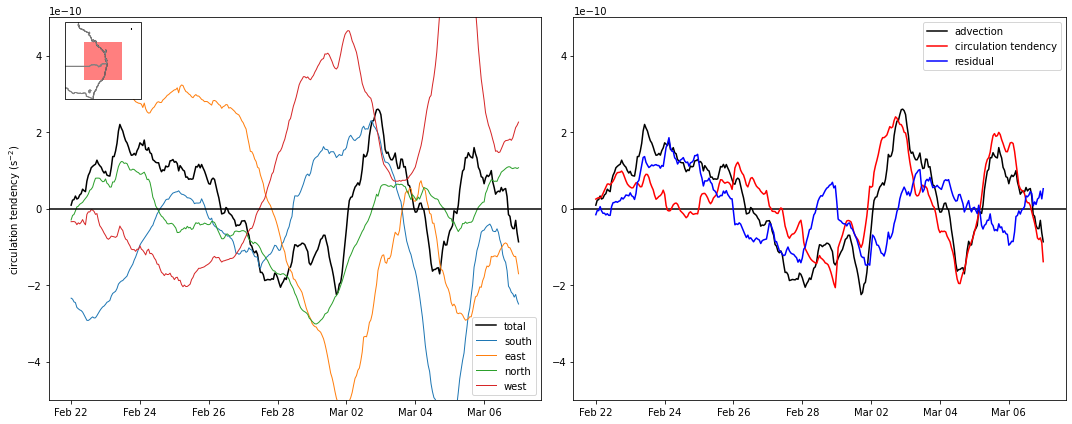

In [28]:
# Time stuff
t = np.arange(len(rv) - 24)
# remove points at end due to 24-point smoothing
times = pd.to_datetime(rv.time.values)[11:-12]
all_times = times.strftime('%b %d %H')
plot_times = times.strftime('%b %d')
t = rv.time[11:-12]

# Create plots

plt.figure(figsize = (15, 6))

# total flux + 4 boundaries
plt.subplot(121)
plt.plot(t, -advtend_all_smooth, label = 'total', color = 'k')
plt.plot(t, -advtend_south_smooth, label = 'south', linewidth = 1)
plt.plot(t, -advtend_east_smooth, label = 'east', linewidth = 1)
plt.plot(t, -advtend_north_smooth, label = 'north', linewidth = 1)
plt.plot(t, -advtend_west_smooth, label = 'west', linewidth = 1)
plt.axhline(color = 'k')
plt.xticks(t.values[::48], plot_times[::48])
plt.ylim((-5e-10, 5e-10))
plt.gca().ticklabel_format(axis='y', style='sci', scilimits=(-10,-10))
plt.ylabel(r'circulation tendency (s$^{-2}$)')
plt.legend()

# # Map inset (first plot only)

axins = inset_axes(plt.gca(), width="20%", height="20%", loc="upper left", 
                   axes_class=cartopy.mpl.geoaxes.GeoAxes, 
                   axes_kwargs=dict(map_projection=ccrs.PlateCarree()))
axins.coastlines()
axins.add_feature(cfeature.STATES, edgecolor='gray')
axins.set_extent((min_lon - 5, max_lon + 5, min_lat - 5, max_lat + 5), crs=ccrs.PlateCarree())

# Shade box on map inset
lats = [min_lat,max_lat,max_lat,min_lat]
lons = [min_lon,min_lon,max_lon,max_lon]
xy = np.array([[min_lon, min_lat], [max_lon, min_lat], [max_lon, max_lat], [min_lon, max_lat]])
poly = Polygon(xy, facecolor='red', alpha=0.5)
plt.gca().add_patch(poly)

# budget closure plot
plt.subplot(122)
plt.plot(t, -advtend_all_smooth, label = r'advection', color = 'k')
plt.axhline(color = 'k')
plt.plot(t, -dC_dt_smooth, label = r'circulation tendency', color = 'r')
plt.plot(t, -advtend_all_smooth + dC_dt_smooth, label = r'residual', color = 'b') #  (no tilt)
plt.xticks(t.values[::48], plot_times[::48])
plt.ylim((-5e-10, 5e-10))
plt.gca().ticklabel_format(axis='y', style='sci', scilimits=(-10,-10))
plt.legend()

plt.tight_layout()

#plt.savefig(f'Documents/Honours/Plots/{min_p}_{max_p}_circulation_{box}.png', dpi = 200, bbox_inches = 'tight')